In [2]:
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from torchvision import models
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torchmetrics
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
from torchvision import transforms
from glob import glob

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [1]:
# !pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 63.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [3]:
import torch.cuda
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Используется:", device)


Используется: cuda


# Загрузим данные

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sorokoladka","key":"a137baa4c9b4a4e228faf7d290dd3081"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dl-2025-competition-1
!unzip dl-2025-competition-1.zip -d data/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/data/train/48/1439.png  
  inflating: data/data/train/48/1440.png  
  inflating: data/data/train/48/1441.png  
  inflating: data/data/train/48/1442.png  
  inflating: data/data/train/48/1443.png  
  inflating: data/data/train/48/1444.png  
  inflating: data/data/train/48/1445.png  
  inflating: data/data/train/48/1446.png  
  inflating: data/data/train/48/1447.png  
  inflating: data/data/train/48/1448.png  
  inflating: data/data/train/48/1449.png  
  inflating: data/data/train/49/1626.png  
  inflating: data/data/train/49/1627.png  
  inflating: data/data/train/49/1628.png  
  inflating: data/data/train/49/1629.png  
  inflating: data/data/train/49/1630.png  
  inflating: data/data/train/49/1631.png  
  inflating: data/data/train/49/1632.png  
  inflating: data/data/train/49/1633.png  
  inflating: data/data/train/49/1634.png  
  inflating: data/data/train/49/1635.png  
  inflating: data/data/train/

In [6]:
train_path = 'data/data/train/'
test_path = 'data/data/test/'

In [7]:
train_images = []
train_labels = []
class_names = sorted(os.listdir(train_path), key=lambda x: int(x))

for class_name in class_names:
    class_dir = os.path.join(train_path, class_name)
    if not os.path.isdir(class_dir):
        continue

    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png')):
            img_path = os.path.join(class_dir, img_name)
            train_images.append(img_path)
            train_labels.append(int(class_name))

print(f"Найдено {len(train_images)} изображений в {len(class_names)} классах")

Найдено 9510 изображений в 100 классах


In [8]:
test_images = []
for img_name in os.listdir(test_path):
    if img_name.lower().endswith(('.png')):
        img_path = os.path.join(test_path, img_name)
        test_images.append(img_path)

print(f"Найдено {len(test_images)} тестовых изображений")

Найдено 3878 тестовых изображений


In [9]:
train_df = pd.DataFrame({'image_path':train_images, 'class':train_labels})
test_df = pd.DataFrame({'image_path':test_images})

# Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы.

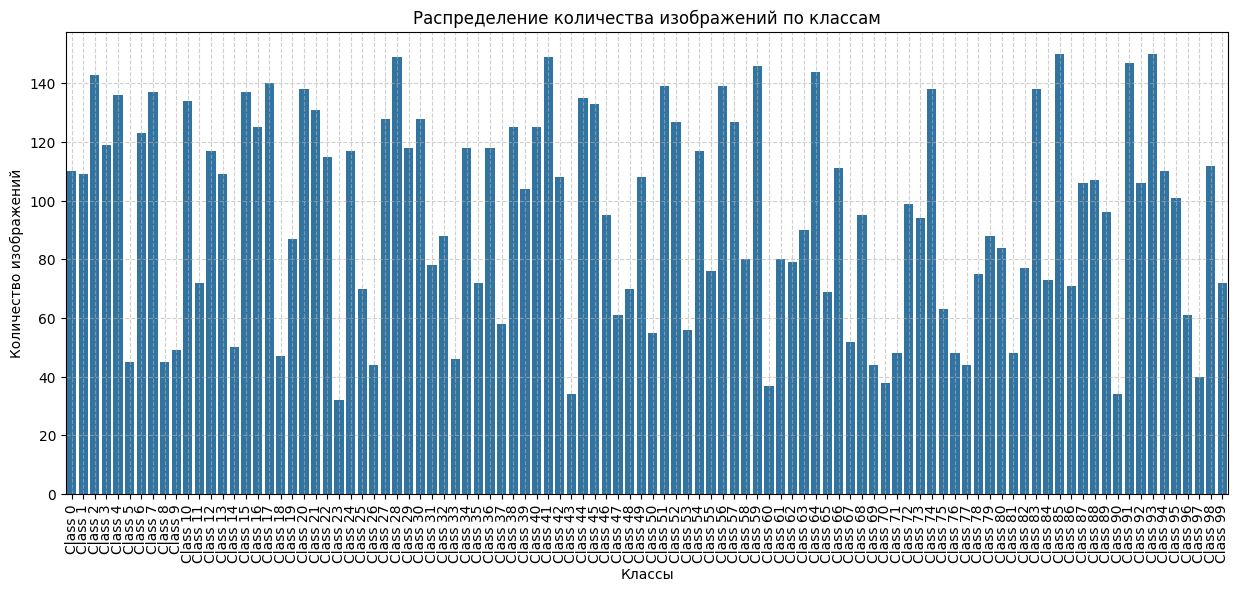

Всего классов: 100
Минимальное количество изображений в классе: 32
Максимальное количество изображений в классе: 150
Среднее количество изображений: 95.1
Медианное количество изображений: 100.0


In [10]:
class_distribution = train_df['class'].value_counts().sort_index()
class_names = [f"Class {i}" for i in class_distribution.index]

plt.figure(figsize=(15, 6))
sns.barplot(x=class_names, y=class_distribution.values)
plt.title('Распределение количества изображений по классам')
plt.xlabel('Классы')
plt.ylabel('Количество изображений')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Всего классов: {len(class_distribution)}")
print(f"Минимальное количество изображений в классе: {class_distribution.min()}")
print(f"Максимальное количество изображений в классе: {class_distribution.max()}")
print(f"Среднее количество изображений: {class_distribution.mean():.1f}")
print(f"Медианное количество изображений: {class_distribution.median()}")

Выведем примеры данных для первых 10 классов (с 0 по 9)

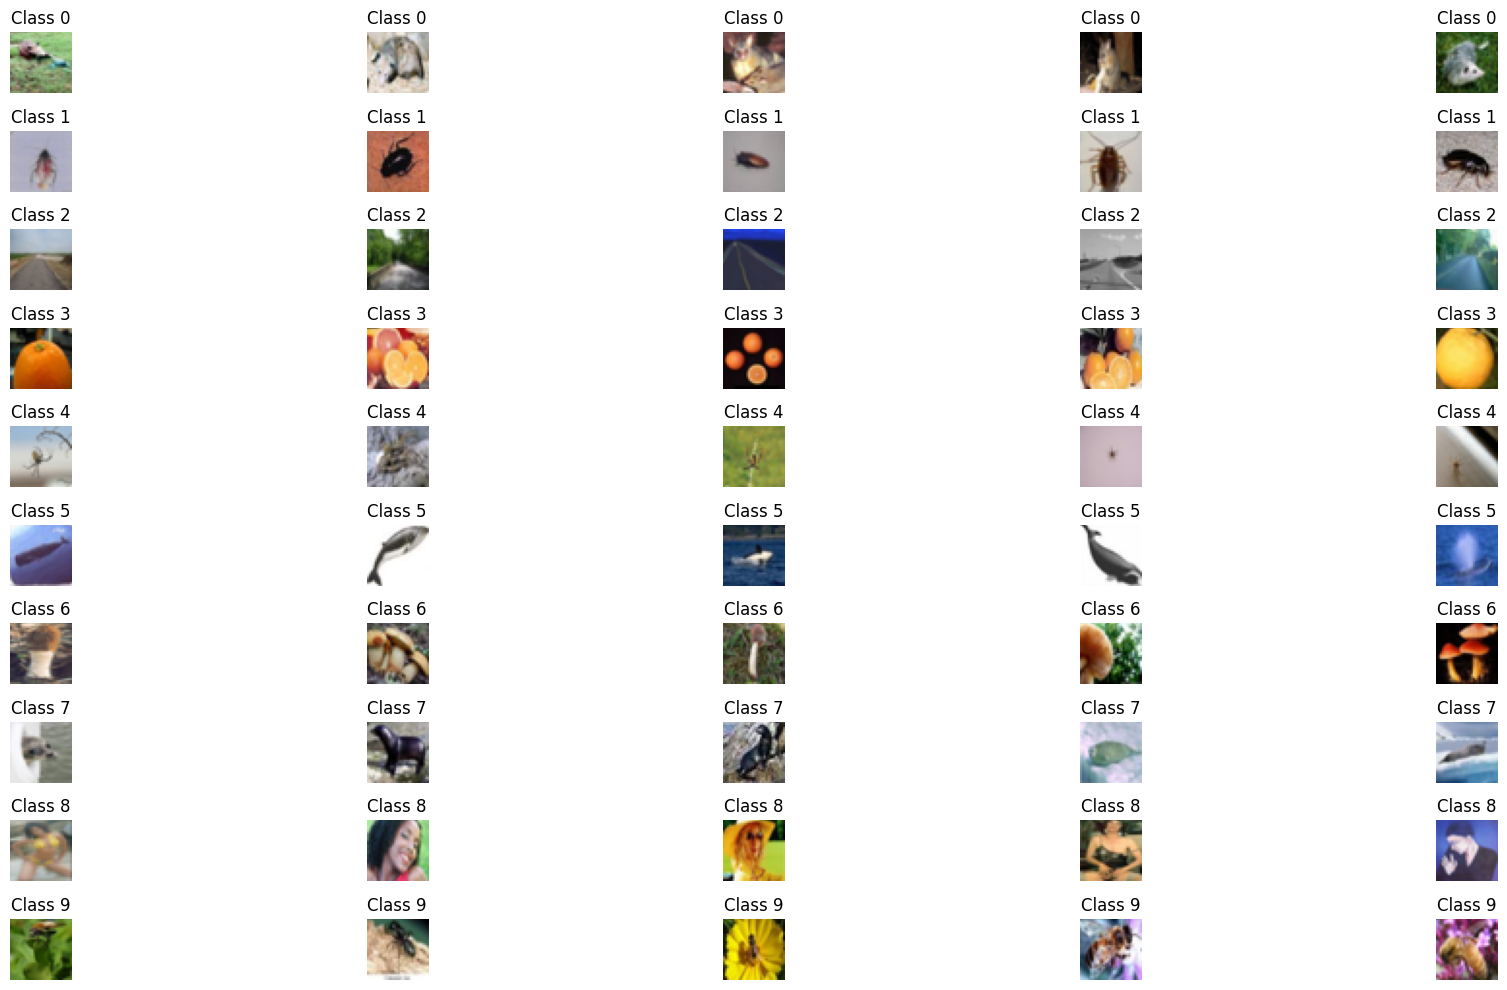

In [11]:
def show_class_samples(df, n_samples=5):
    unique_classes = df['class'].unique()
    plt.figure(figsize=(20, 10))

    for i, class_id in enumerate(unique_classes[:10]):
        class_samples = df[df['class'] == class_id].sample(n_samples)

        for j, (_, row) in enumerate(class_samples.iterrows()):
            img = Image.open(row['image_path'])
            plt.subplot(len(unique_classes[:10]), n_samples, i*n_samples + j + 1)
            plt.imshow(img)
            plt.title(f"Class {class_id}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_class_samples(train_df)

**Выводы:**
1. Умеренный дисбаланс классов: от 32 до 150 изображений на класс
2. В классе изображения могут сильно различаться по освещенности <br>(например, в выведенных классах)
3. Размеры одинаковые (32 на 32 - по условию, но есть "пропуски" в картинках (по пикселям)

# Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель.

Добавим много разных аугментаций

In [12]:
def complicated_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.3),
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.1,
            rotate_limit=10,
            p=0.5
        ),

        A.RandomBrightnessContrast(
            brightness_limit=0.15,
            contrast_limit=0.15,
            p=0.5
        ),

        A.HueSaturationValue(
            hue_shift_limit=5,
            sat_shift_limit=15,
            val_shift_limit=10,
            p=0.3
        ),

        A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),
        A.CoarseDropout(
            max_holes=2,
            max_height=8,
            max_width=8,
            fill_value=0,
            p=0.1
        ),

        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])


In [13]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['class']

        image = np.array(Image.open(img_path).convert('RGB'))
        assert image.shape == (32, 32, 3), f"Неверный размер: {img_path} - {image.shape}"

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label, dtype=torch.long)

Посмотрим как работают наши аугментации

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-12-da947c4cbc63>:25: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),
<ipython-input-12-da947c4cbc63>:26: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


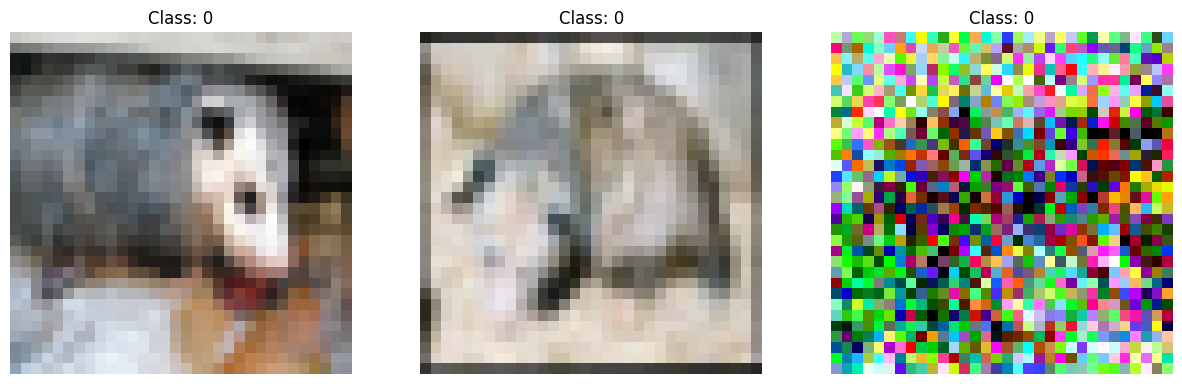

In [14]:
def plot_augmentations(dataset, n=3):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f"Class: {label}")
        axes[i].axis('off')
    plt.show()

train_dataset = CustomDataset(df=train_df, transform=complicated_train_transform())
plot_augmentations(train_dataset)

# Поделить данные на трейн-валидацию, обучить базовую модель (с и без transfer learning) без навороченных аугментаций (только отражение во горизонтали и вертикали) и с навороченными. Попробуйте применить продвинутые методы апскейлинга для подачи модели нужного размера для transfer learning. Проверить результаты моделей с аугментацией на тесте и без. Сделать аугментацию моделей на валидации (или тесте на каггле). Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом.

Делим данные (учитывая дисбаланс)

In [15]:
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['class'],
    random_state=42,
    shuffle=True
)

Создаём базовый трансформер (только отражения и нормализация)

In [16]:
basic_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

Создаём навороченный трансформер (геометрия, цвет, шум)

In [17]:
advanced_transform = A.Compose([
    # A.SmallestMaxSize(max_size=64),  # Сначала увеличиваем до 64px
    # A.RandomCrop(height=56, width=56),  # Затем случайный кроп
    # A.Resize(height=224, width=224),  # Итоговый размер для Transfer Learning

    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.1),

    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(p=0.3),

    A.GaussNoise(var_limit=(10.0, 50.0), p=0.1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-17-259bb8a003e2>:7: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.1),
<ipython-input-17-259bb8a003e2>:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.1),


Содаём продуманный трансформер (его используем по умолчанию)

In [18]:
train_transform = A.Compose(
    [
        A.Resize(height=224, width=224, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.2),
        A.HorizontalFlip(p=0.2),
        # A.VerticalFlip(p=0.1),
        A.RandomRotate90(p=0.2),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 1), lightness=(0.5, 1.5), p=0.6),
        A.Normalize(),
        ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.Resize(224, 224, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

Будем использовать встроенные модули для обучения (LightingModule)

In [19]:
class LitModel(LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=100)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=100)

        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

    def forward(self, x):
        return self.model(x)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        self.val_acc(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.lr)
        scheduler = {
            'scheduler': OneCycleLR(
                optimizer,
                max_lr=self.lr,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=0.1
            ),
            'interval': 'step'
        }
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)

        self.train_acc(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_acc, prog_bar=True)

        return loss

    def predict(self, x):
        with torch.no_grad():
            self.eval()
            logits = self(x)
        return torch.argmax(logits, dim=1)

    def on_train_epoch_end(self):
        self.train_loss_history.append(self.trainer.callback_metrics["train_loss"].item())
        self.train_acc_history.append(self.trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self):
        if "val_loss" in self.trainer.callback_metrics:
            self.val_loss_history.append(self.trainer.callback_metrics["val_loss"].item())
            self.val_acc_history.append(self.trainer.callback_metrics["val_acc"].item())


In [20]:
def run_experiment(model, model_name, epoch_num, train_transform=train_transform):
    try:
        print(f"\n=== Starting experiment: Model={model_name} ===")

        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=5,
            mode="min",
            check_on_train_epoch_end=False
        )

        checkpoint = ModelCheckpoint(
            monitor="val_acc",
            mode="max",
            filename=f"best-{model_name}-" + "{epoch}-{val_acc:.2f}",
            save_top_k=1
        )

        train_ds = CustomDataset(train_df, transform=train_transform)
        val_ds = CustomDataset(val_df, transform=val_transform)

        class_counts = train_df['class'].value_counts().sort_index().values
        class_weights = 1. / class_counts
        samples_weights = class_weights[train_df['class'].values]

        sampler = WeightedRandomSampler(
            weights=samples_weights,
            num_samples=len(samples_weights),
            replacement=True
        )

        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224)
            out = model(dummy)
            print(f"Тест модели: вход {dummy.shape} -> выход {out.shape}")

        lit_model = LitModel(model)
        trainer = Trainer(
            max_epochs=epoch_num,
            callbacks=[early_stop, checkpoint],
            accelerator="auto",
            devices=1,
            logger=TensorBoardLogger("logs/", name=model_name),
            deterministic=False,
            enable_progress_bar=True,
            limit_train_batches=1.0,
            limit_val_batches=1.0
        )

        trainer.fit(
            lit_model,
            DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=2),
            DataLoader(val_ds, batch_size=32, num_workers=2)
        )

        plot_metrics(
            lit_model.train_loss_history,
            lit_model.val_loss_history,
            lit_model.train_acc_history,
            lit_model.val_acc_history
        )

        return {
            "best_val_loss": early_stop.best_score,
            "best_val_acc": checkpoint.best_model_score.item()
        }

    except Exception as e:
        print(f"Error: {str(e)}")
        return None

Будем рассматривать 3 модели (2 из них - предобученные)

In [21]:
def create_resnet18(num_classes=100):
    model = models.resnet18(pretrained=True)
    # for param in model.parameters():
    #     param.requires_grad = False
    # for param in model.layer4.parameters():
    #     param.requires_grad = True
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def create_efficientnet(num_classes=100):
    model = models.efficientnet_b0(pretrained=True)
    # for param in model.parameters():
    #     param.requires_grad = False
    # for param in model.features[-3:].parameters():
    #     param.requires_grad = True
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

def create_simple_cnn(num_classes=100):
    model = nn.Sequential(
        nn.Conv2d(3, 32, 3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, 3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, 3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(128*4*4, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    return model

Для отрисовки лосей и акураси

In [22]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]



=== Starting experiment: Model=resnet18 ===
Тест модели: вход torch.Size([1, 3, 224, 224]) -> выход torch.Size([1, 100])


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


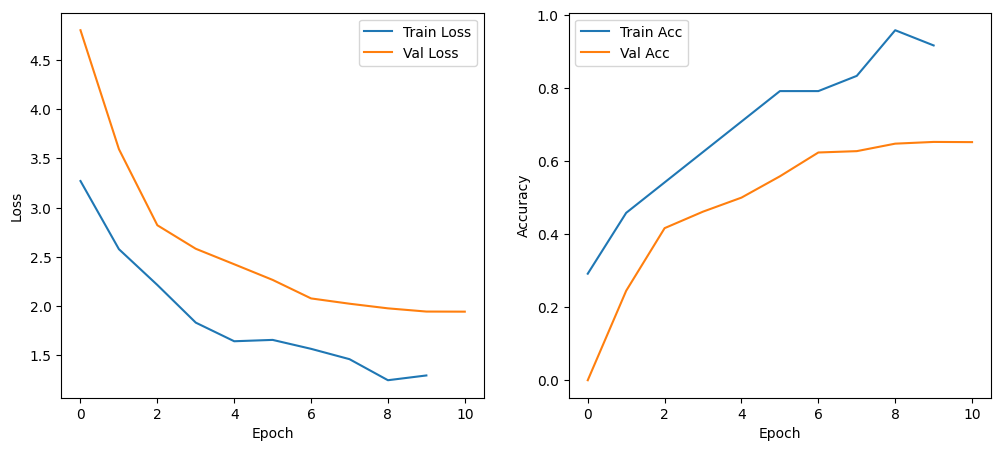

In [23]:
resnet_model = create_resnet18()
results_resnet = run_experiment(resnet_model, "resnet18", 10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 131MB/s] 
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches pe


=== Starting experiment: Model=efficientnet ===
Тест модели: вход torch.Size([1, 3, 224, 224]) -> выход torch.Size([1, 100])


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 4.1 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.543    Total estimated model params size (MB)
340       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


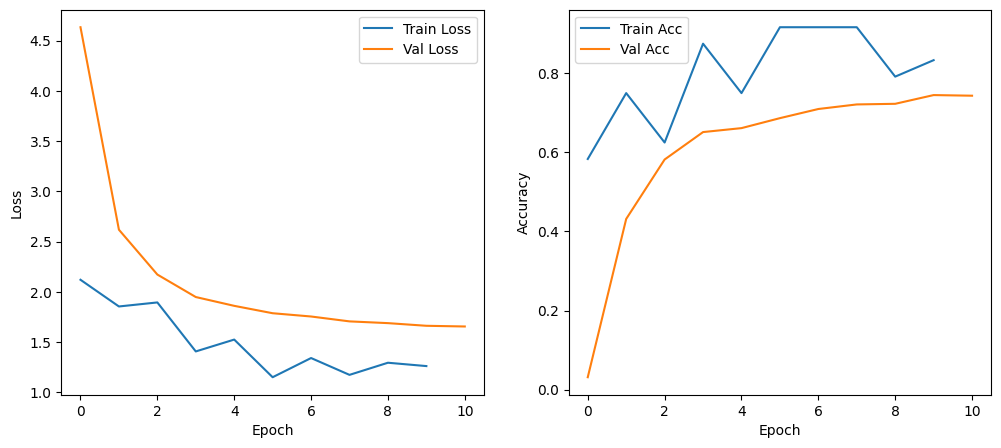

In [24]:
effnet_model = create_efficientnet()
results_effnet = run_experiment(effnet_model, "efficientnet", 10)

Efficient net сработала лучше (по валидации). Она, конечно, несколько переобучается. Можно заморозить часть слоёв, чтобы избавиться от этого. В следующей ячейке я пробую разные аугментации (кроме `train_transform` попробуем `basic_transform` и `advanced_transform`)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.



=== Starting experiment: Model=efficientnet ===
Тест модели: вход torch.Size([1, 3, 224, 224]) -> выход torch.Size([1, 100])


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 4.1 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.543    Total estimated model params size (MB)
340       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


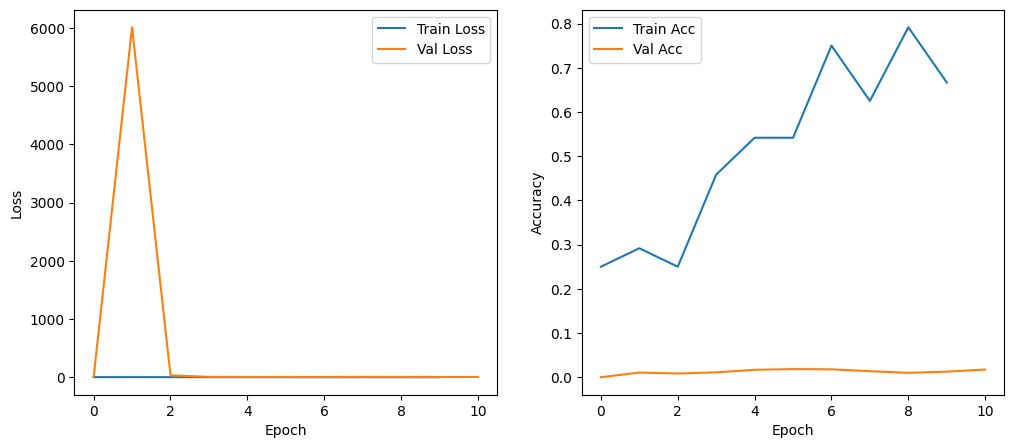

In [25]:
effnet_model = create_efficientnet()
results_effnet = run_experiment(effnet_model, "efficientnet", 10, basic_transform)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.



=== Starting experiment: Model=efficientnet ===
Тест модели: вход torch.Size([1, 3, 224, 224]) -> выход torch.Size([1, 100])


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 4.1 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.543    Total estimated model params size (MB)
340       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


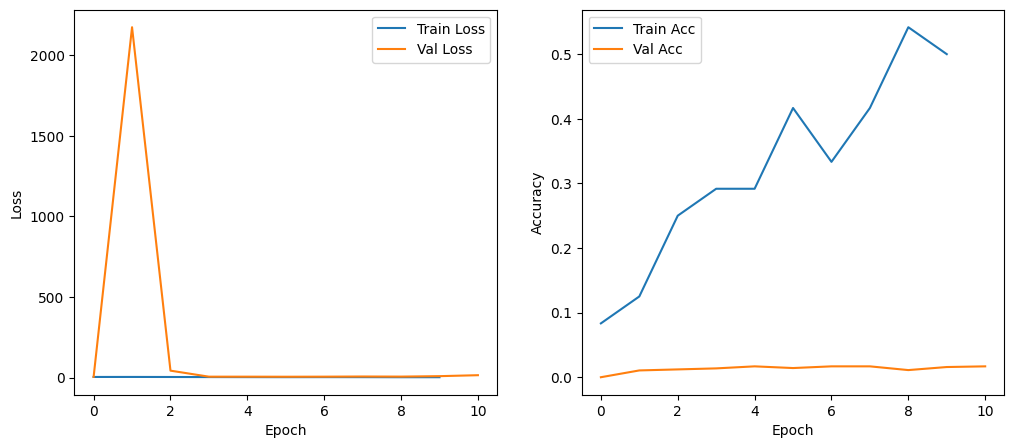

In [26]:
effnet_model = create_efficientnet()
results_effnet = run_experiment(effnet_model, "efficientnet", 10, advanced_transform)

Убеждаемся, что effnet модель и `train_transform` (изначальный) показывают лучший скор на валидации - его и будем использовать для сабмишн (увеличив максимальное число эпох).

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.



=== Starting experiment: Model=efficientnet ===
Тест модели: вход torch.Size([1, 3, 224, 224]) -> выход torch.Size([1, 100])


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | EfficientNet       | 4.1 M  | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
---------------------------------------------------------
4.1 M     Trainable params
0         Non-trainable params
4.1 M     Total params
16.543    Total estimated model params size (MB)
340       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


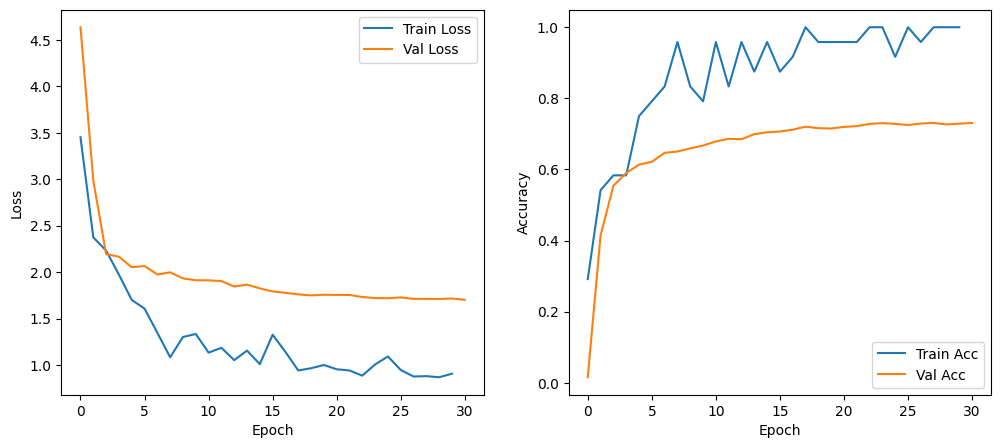

In [27]:
effnet_model = create_efficientnet()
results_effnet = run_experiment(effnet_model, "efficientnet", 30)

Перейдём к предсказанию (надо вписывать путь!)

In [29]:
checkpoint_path = "/content/logs/efficientnet/version_3/checkpoints/best-efficientnet-epoch=26-val_acc=0.73.ckpt"#

model = effnet_model
lit_model = LitModel.load_from_checkpoint(checkpoint_path, model=model)
# lit_model.eval()
lit_model.cuda()

LitModel(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activa

In [30]:
def predict_on_test(model, test_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            images, _ = batch
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [31]:
test_df['class'] = 0 #кастыль, т.к. в тесте нет столбца, а `CustomDataset` его ожидает
test_dataset = CustomDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32)
preds = predict_on_test(model, test_loader, device)

In [32]:
test_df['target'] = preds
test_df['id'] = test_df['image_path'].apply(lambda x: x[15:-4])
test_df['id'] = test_df['id'].astype('int')
submission = test_df[['id','target']].set_index('id').sort_index()
submission#.to_csv('submission.csv')

,target
id,
0,71
1,62
2,18
3,41
4,66
...,...
3873,94
3874,42
3875,95


#### Обучить простенький генератор для дополнительной аугментации данных, настроить для него условную генерацию на классах и аугментационный пайплайн. Изучить влияние сгенерированных данных на перформанс модели.

Напишем дискриминатор и генератор

In [33]:
import torch.optim as optim
class Discriminator(nn.Module):
    def __init__(self, num_classes=100, img_channels=3):
        super().__init__()
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
        )

        self.conv_output_size = 1024 * 7 * 7
        self.adv_layer = nn.Sequential(
            nn.Linear(self.conv_output_size + num_classes, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img = img.to(device)
        labels = labels.to(device)

        features = self.conv_layers(img)
        features = features.view(features.size(0), -1)

        label_emb = self.label_emb(labels)

        concat = torch.cat([features, label_emb], dim=1)

        validity = self.adv_layer(concat)
        return validity

In [34]:
class Generator(nn.Module):
    def __init__(self, num_classes=100, latent_dim=128, img_channels=3):
        super().__init__()
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = 14

        self.l1 = nn.Linear(latent_dim + num_classes, 1024 * self.init_size**2)

        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.Conv2d(64, img_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        noise = noise.to(device)
        labels = labels.to(device)

        gen_input = torch.cat((self.label_emb(labels), noise), -1)

        out = self.l1(gen_input)
        out = out.view(out.size(0), 1024, self.init_size, self.init_size)

        img = self.conv_blocks(out)
        return img


Функция для его обучения

In [35]:
def train_cgan(generator, discriminator, train_loader, num_epochs=1, device=device):
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0003, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.5, 0.999))

    adversarial_loss = nn.BCELoss()

    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(train_loader):
            batch_size = imgs.size(0)

            real_imgs = imgs.to(device)
            labels = labels.to(device)

            if real_imgs.dim() == 3:
                real_imgs = real_imgs.unsqueeze(1)
            if real_imgs.size(1) == 1:
                real_imgs = real_imgs.repeat(1, 3, 1, 1)

            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)

            noise = torch.randn(batch_size, generator.latent_dim, device=device)
            gen_labels = torch.randint(0, generator.num_classes, (batch_size,), device=device)
            gen_imgs = generator(noise, gen_labels).detach()
            fake_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            optimizer_G.zero_grad()
            noise = torch.randn(batch_size, generator.latent_dim, device=device)
            gen_labels = torch.randint(0, generator.num_classes, (batch_size,), device=device)
            gen_imgs = generator(noise, gen_labels)
            g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
            g_loss.backward()
            optimizer_G.step()

            if i % 100 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}")
    return generator, discriminator

здесь собсна обучение (всего 10 эпох, потому что чето долго обучается ~4 минуты одна эпоха на cuda), но главное, что работает ваще

In [36]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

gan_train_ds = CustomDataset(train_df, transform=val_transform)
gan_train_loader = DataLoader(gan_train_ds, batch_size=32, shuffle=True)

train_cgan(generator, discriminator, gan_train_loader, num_epochs=10)

[Epoch 0/10] [Batch 0/238] [D loss: 0.7335] [G loss: 0.9363
[Epoch 0/10] [Batch 100/238] [D loss: 0.3075] [G loss: 2.3659
[Epoch 0/10] [Batch 200/238] [D loss: 0.1764] [G loss: 3.2765
[Epoch 1/10] [Batch 0/238] [D loss: 0.1179] [G loss: 3.0717
[Epoch 1/10] [Batch 100/238] [D loss: 0.3359] [G loss: 16.4391
[Epoch 1/10] [Batch 200/238] [D loss: 0.0012] [G loss: 15.6477
[Epoch 2/10] [Batch 0/238] [D loss: 0.0006] [G loss: 11.5238
[Epoch 2/10] [Batch 100/238] [D loss: 0.0016] [G loss: 10.5208
[Epoch 2/10] [Batch 200/238] [D loss: 0.0004] [G loss: 10.3011
[Epoch 3/10] [Batch 0/238] [D loss: 0.0002] [G loss: 11.2910
[Epoch 3/10] [Batch 100/238] [D loss: 0.0226] [G loss: 8.8491
[Epoch 3/10] [Batch 200/238] [D loss: 0.0004] [G loss: 9.3383
[Epoch 4/10] [Batch 0/238] [D loss: 0.0042] [G loss: 8.5344
[Epoch 4/10] [Batch 100/238] [D loss: 0.0022] [G loss: 13.0260
[Epoch 4/10] [Batch 200/238] [D loss: 0.0000] [G loss: 12.7306
[Epoch 5/10] [Batch 0/238] [D loss: 0.0002] [G loss: 11.1903
[Epoch 5/10

(Generator(
   (label_emb): Embedding(100, 100)
   (l1): Linear(in_features=228, out_features=200704, bias=True)
   (conv_blocks): Sequential(
     (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
     (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (11): ReLU(inplace=True)
     (12): Conv2d(64, 3, ker

Генерируем изображение класса с жуками (1)

In [39]:
noise = torch.randn(1, generator.latent_dim).to(device)
label = torch.tensor([1]).to(device)
with torch.no_grad():
    generated_image = generator(noise, label).cpu()

Отображаем изображение

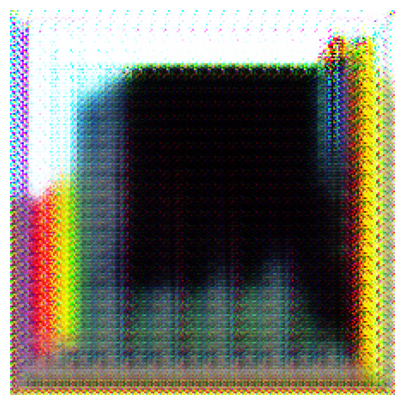

In [40]:
img = generated_image.squeeze().permute(1, 2, 0).numpy()
img = (img + 1) / 2

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.show()

Я не буду добавлять генератор для доп аугментации, потому что на данном этапе разработки он, по моему мнению, будет вносить больше шума, чем скора